# Representing image using matching pursuit (MP) with Gaussian basis functions

This notebook uses a variant of the matching pusuit algorithm (Elad, 2014) to decompose a frame from a microscopy video into a weighted sum of Gaussian basis functions.

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import ndimage
from scipy.stats import multivariate_normal
from skimage.filters import threshold_otsu

from otimage import imagerep, utils, viewers, io

## Load Zimmer data

In [3]:
# Path to file containing Zimmer data
in_fpath = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'

# Index of frame to use
t_frame = 5

with io.ZimmerReader(in_fpath) as reader:
    units = reader.units
    img_full = reader.get_frame(t_frame)

## Select section of frame for test image

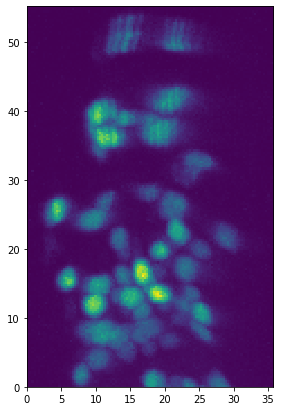

In [4]:
# Section of XY plane where head is found
(xmin, xmax) = (420, 530)
(ymin, ymax) = (350, 520)

# Extract section
img = img_full[xmin:xmax, ymin:ymax, :]

# Display max projection
fig, ax = plt.subplots(figsize=(7, 7))
utils.plot_maxproj_units(img, units, ax=ax);

## Threshold image

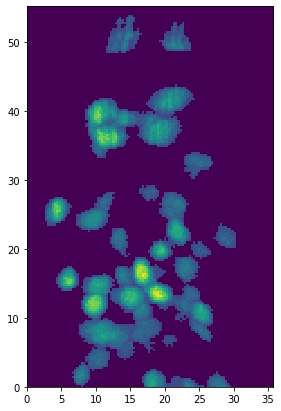

In [5]:
th_otsu = threshold_otsu(img)

img_th = np.copy(img)
img_th[img_th < th_otsu] = 0.0

# Display max projection
fig, ax = plt.subplots(figsize=(7, 7))
utils.plot_maxproj_units(img_th, units, ax=ax);

## Create Gaussian filter for matching pursuit

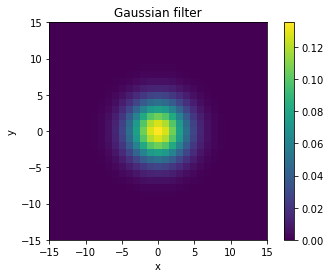

In [6]:
wx = 15
wy = 15
wz = 5
xg, yg, zg = np.mgrid[-wx:wx+1, -wy:wy+1, -wz:wz+1]
fl_grid = np.stack((xg, yg, zg), axis=-1)

mean = np.array([0, 0, 0]) 
cov = np.diag([8.0, 8.0, 1.5])
fl_nn = multivariate_normal.pdf(fl_grid, mean=mean, cov=cov)
fl = fl_nn / np.sqrt(np.sum(fl_nn ** 2))

plt.imshow(np.max(fl, 2).T, origin='lower', extent=[-15, 15, -15, 15])
plt.title('Gaussian filter')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar();

## Run matching pursuit on test image

In [7]:
%%time
pts, wts, img_conv = imagerep.greedy_mp(img_th, fl, 300)

CPU times: user 15.9 s, sys: 501 ms, total: 16.4 s
Wall time: 16.4 s


## Reconstruct image using MP components

In [9]:
recon_img = np.zeros((img.shape[0] + 2 * wx, img.shape[1] + 2 * wy, img.shape[2] + 2 * wz))
points_mod = pts + np.array([wx, wy, wz])

for i in range(points_mod.shape[0]):
    
    pt = points_mod[i]
    
    x_sl = slice(pt[0] - wx, pt[0] + wx + 1)
    y_sl = slice(pt[1] - wy, pt[1] + wy + 1)
    z_sl = slice(pt[2] - wz, pt[2] + wz + 1)
    
    recon_img[x_sl, y_sl, z_sl] += wts[i] * fl
    
r_img = recon_img[wx:-wx, wy:-wy, wz:-wz]

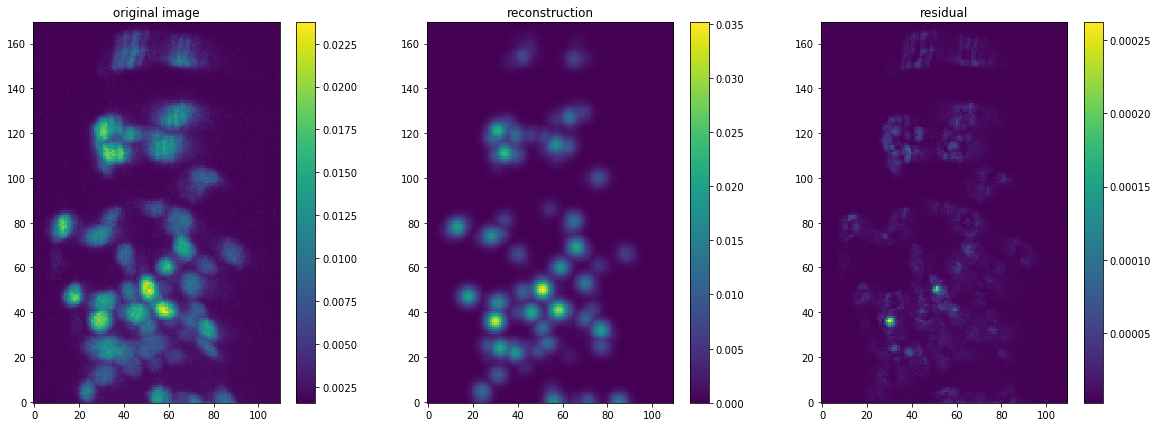

In [10]:
sq_res_img = (r_img - img) ** 2

plt.figure(figsize=(20, 7))

plt.subplot(131)
plt.imshow(np.max(img, 2).T, origin='lower')
#utils.plot_maxproj_units(img, units)
plt.colorbar()
plt.title('original image')

plt.subplot(132)
plt.imshow(np.max(r_img, 2).T, origin='lower')
#utils.plot_maxproj_units(r_img, units)
plt.colorbar()
plt.title('reconstruction')

plt.subplot(133)
plt.imshow(np.max(sq_res_img, 2).T, origin='lower')
#utils.plot_maxproj_units(sq_res_img, units)
plt.colorbar()
plt.title('residual');

#plt.savefig('greedy_mp_1.png')

In [20]:
viewers.WormCompareViewer(img, r_img, units);

interactive(children=(RadioButtons(description='plane:', options=('XY', 'XZ', 'YZ'), style=DescriptionStyle(de…